In [2]:
import numpy as np
import pandas as pd
import os
import glob
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
import yfinance as yf
from scipy import stats

In [3]:
DATA_PATH    = 'downloader-data'
TICKERS_PATH = 'tickers'

## 1 - data collection

берем все тикеры с фондовых рынков Японии(JPX), 
Индии(NIFTY) и США(NASDAQ). 

загружаем все тикеры и все имеющиеся для них данные за последний год

### read tickers

In [4]:
ticker_files = glob.glob(f'{TICKERS_PATH}/*')
ticker_dfs = []
for tf in ticker_files:
    ticker_dfs.append(pd.read_csv(tf))

tickers = pd.concat(ticker_dfs, ignore_index=True)


### read data

In [5]:
data_for_ticker = {}
for index, (ticker, name) in tickers.iterrows():
    try:
        df = pd.read_csv(f'{DATA_PATH}/{ticker}.csv')
        if len(df) > 100:
            data_for_ticker[ticker] = df
    except:
        pass
    
print(data_for_ticker['AAPL'])

           Date       Close     Volume
0    2020-10-27  116.599998   92276800
1    2020-10-28  111.199997  143937800
2    2020-10-29  115.320000  146129200
3    2020-10-30  108.860001  190272600
4    2020-11-02  108.769997  122866900
..          ...         ...        ...
248  2021-10-21  149.479996   61421000
249  2021-10-22  148.690002   58839600
250  2021-10-25  148.639999   50720600
251  2021-10-26  149.320007   60893400
252  2021-10-27  148.850006   55951800

[253 rows x 3 columns]


## 2 - assets map

считаем логарифмические доходности каждого актива

In [6]:
for ticker, data in data_for_ticker.items():
    data_for_ticker[ticker] = data.assign(logret=np.log(data.Close).diff())
    data_for_ticker[ticker]['minus_logret'] = data_for_ticker[ticker]['logret'].mul(-1)

In [1]:
data_for_ticker['AAPL']['Close']

NameError: name 'data_for_ticker' is not defined

### compute logret_mean, logret_std

посчитаем ожидаемые доходности, дисперсии доходностей для каждого актива

In [8]:
estims = pd.DataFrame(data=[], columns=['ticker', 'logret_mean', 'logret_std'])
estims.set_index('ticker', inplace=True)

for ticker, data in data_for_ticker.items():
    estims.loc[ticker] = [data['logret'].mean(), data['logret'].std()]

indices_tickers = ['JPN', '^IXIC', '^NSEI']     
estims

logret_mean  logret_std
ticker                         
JPN        0.000627    0.009736
^IXIC      0.001387    0.011009
^NSEI      0.001701    0.009721
ATEYY      0.001674    0.024739
AONNY     -0.000562    0.021216
...             ...         ...
UPRO       0.003376    0.024899
LIFE       0.003917    0.064695
FLOT       0.000009    0.000302
AQUA       0.002118    0.023276
INGR       0.000886    0.015232

[2129 rows x 2 columns]

### plot the map

построим карту всех активов в координатах (σ, E)

In [9]:
import plotly.express as px
from sklearn.preprocessing import normalize

ticker_colour = estims['logret_mean'] / estims['logret_std']
ticker_size = (ticker_colour - ticker_colour.min()) / ticker_colour.max()
fig_all = px.scatter(estims, x='logret_std', y='logret_mean',
                 hover_name=estims.index, 
                 color_continuous_scale=px.colors.diverging.RdYlGn,
                 color=ticker_colour)
fig_all.show()

 Для построения портфелей выберем 50 активов с наибольшей инвестиционной привлекательностью 
 
 Были выбраны активы с наибольшим отношением доходности к риску с учитывались показатели 'p/e' и
 'p/s' (недооцененность компаний на рынке).

In [10]:
ticker_colour.sort_values(ascending=False)
portfolio = ticker_colour.sort_values(ascending=False)[:50]
tickers = portfolio.keys()
tickers = list(tickers)
print(tickers)

['PRFT', 'ANAT', 'III', 'WIRE', 'OFS', 'DXLG', 'PMBC', 'FTNT', 'CG', 'GAIN', 'SBNY', '^NSEI', 'TGA', 'TRNS', 'AAVAS', 'PDBC', 'JYNT', 'CRAI', 'CSWC', 'ARLP', 'UHAL', 'ADANIGREEN', 'JCOM', 'ATLC', 'ORMP', 'NYMTP', 'CBNK', 'GOOG', 'TBBK', 'TGLS', 'HMNF', 'ANGO', 'PNNT', 'COMT', 'ARCC', 'GOOGL', 'HMHC', 'OMCL', 'SFBS', 'LPLA', 'VNOM', 'NDAQ', 'RDVY', 'CAR', 'SLCT', 'GLAD', 'WVVI', 'SIVB', 'BRKR', 'CRVL']


In [11]:
joint_data = pd.DataFrame(data=[], columns=[])
joint_data['Date'] = data_for_ticker[tickers[0]]['Date'][1:]

for ticker in tickers:
    data = data_for_ticker[ticker]
    joint_data[ticker] = data['logret'][1:]
    
joint_data = joint_data.dropna()
del joint_data['Date']
joint_data


PRFT      ANAT       III      WIRE       OFS      DXLG      PMBC  \
1   -0.060564 -0.015323 -0.014670 -0.021321 -0.019513 -0.036368  0.000000   
2   -0.008811  0.015613  0.000000  0.004994 -0.012392  0.000000  0.000000   
3    0.019078 -0.003917  0.009804  0.000866 -0.010025 -0.037740 -0.002692   
4    0.024967  0.025685  0.019324  0.020774  0.019951  0.000000  0.039635   
5    0.043856  0.023797  0.018958  0.009703 -0.007435  0.037740  0.077249   
..        ...       ...       ...       ...       ...       ...       ...   
240  0.000165 -0.003372 -0.017253  0.014772  0.000000 -0.081009  0.023175   
241  0.023865  0.002951  0.006671  0.007353  0.006626  0.052460 -0.001994   
242  0.020148 -0.003162 -0.003997 -0.003573 -0.007576  0.003401 -0.007011   
243  0.027634 -0.001003 -0.008043  0.041313  0.029965  0.003390 -0.024416   
244 -0.008350 -0.001269 -0.024524  0.027105  0.015561  0.036549 -0.020812   

         FTNT        CG      GAIN  ...      VNOM      NDAQ      RDVY  \
1   -0.043432 -0.023956 -0.037696  ... -0.076525 -0.027308 -0.031135   
2   -0.008019  0.015773 -0.015729  ...  0.030459  0.002298  0.015180   
3   -0.066846 -0.025358  0.015729  ...  0.001428 -0.008395 -0.006429   
4    0.001991  0.018685  0.019026  ...  0.029517  0.017939  0.017124   
5    0.016323 -0.001971  0.008211  ...  0.035378  0.013947  0.024182   
..        ...       ...       ...  ...       ...       ...       ...   
240 -0.001205 -0.010578  0.003540  ...  0.003027  0.001417 -0.003698   
241 -0.000717  0.007538  0.002118  ...  0.004738 -0.001012 -0.003298   
242  0.011416  0.011703  0.024383  ... -0.008632 -0.000304  0.000206   
243  0.011893  0.028477  0.001376  ...  0.008202  0.016179  0.021041   
244  0.004705  0.003115  0.010937  ...  0.031319  0.011792  0.007853   

          CAR      SLCT      GLAD      WVVI      SIVB      BRKR      CRVL  
1   -0.023054 -0.023083 -0.021113 -0.003236 -0.038801 -0.034556 -0.015496  
2    0.042868  0.059978  0.021113  0.001619  0.012594  0.018023  0.012766  
3   -0.086170 -0.036895  0.017944 -0.011391  0.030137  0.013013 -0.002518  
4   -0.098225  0.044627  0.005457  0.008150  0.054491  0.034426  0.013934  
5    0.001637  0.035313 -0.012320 -0.009788  0.011627 -0.001136 -0.069843  
..        ...       ...       ...       ...       ...       ...       ...  
240  0.030149  0.040719  0.000879  0.135678 -0.005954 -0.011995 -0.018415  
241  0.074133  0.000985 -0.004403 -0.010974 -0.011195 -0.009224  0.014019  
242 -0.023282 -0.033528  0.000000 -0.003454  0.013009 -0.009176 -0.007488  
243 -0.017977 -0.015385  0.004403  0.016473  0.023928  0.019318  0.018180  
244  0.025357 -0.024589  0.004384  0.004754  0.009373  0.011984  0.015054  

[244 rows x 50 columns]

### Compute logret_mean,  logret_std for the tickers 

In [12]:
logret_mean = joint_data.mean()
logret_std =  joint_data.cov()

### Compute logret_mean, logret_std by portfolio weights

найдем σ, E для равномерного портфеля:

In [13]:
import math

def get_portfolio_coordinates(weights,
                              _tickers=tickers,
                              _logret_mean=logret_mean,
                              _logret_std=logret_std):
    portfolio_logret_mean = 0
    portfolio_logret_std = 0
     
    for i in range(len(_tickers)):
        portfolio_logret_mean += weights[i] * _logret_mean[i]
        for j in range(len(_tickers)):
            portfolio_logret_std += weights[i] * weights[j] * _logret_std.loc[_tickers[i], _tickers[j]]
            
    portfolio_logret_std = math.sqrt(portfolio_logret_std)
    return portfolio_logret_std, portfolio_logret_mean 

### Uniform portfolio logret_mean, logret_std

In [14]:
uniform_weights = [1/len(tickers)]*len(tickers)
uniform_logret_std, uniform_logret_mean = get_portfolio_coordinates(uniform_weights)
print(f'Uniform portfolio (std, mean): ({uniform_logret_std}, {uniform_logret_mean})')

Uniform portfolio (std, mean): (0.010614199709276174, 0.003931380778702223)


In [15]:
import random

def getRandomWeights(n, shorts=False):
    left, right = 0, 100    
    if shorts:
        left = -100     
    weights = [random.randint(left, right) for i in range(0, n)]
    weights = [weight/sum(map(abs, weights)) for weight in weights]
    return weights

## Portfolio without short sales

строим эффективный фронт в случае без коротких продаж

добавляем на график фронта координаты равномерного портфеля и индексов трех финансовых рынков

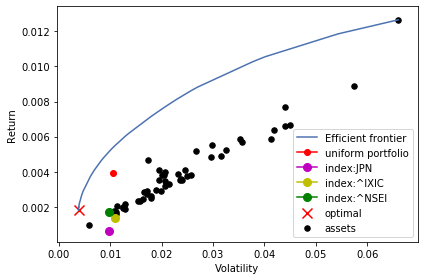

In [16]:
import matplotlib.pyplot as plt

ef_no_shorts = CLA(logret_mean, logret_std, weight_bounds=(0,1))

minvol_ef = ef_no_shorts.min_volatility()
minvol_ef_pwt = ef_no_shorts.clean_weights()

ef_plt_no_shorts = efficient_frontier_no_shorts = pplt.plot_efficient_frontier(ef_no_shorts, showfig = False)
ef_plt_no_shorts.plot(uniform_logret_std, uniform_logret_mean, '-ro', label='uniform portfolio')

# plot indices
color_forms = ['-mo', '-yo', '-go']
for iticker, _color_form in zip(indices_tickers, color_forms):
    index_logret_mean, index_logret_std = estims.loc[iticker]
    ef_plt_no_shorts.plot(index_logret_std, index_logret_mean, 
                          _color_form,  markersize=8, label=f'index:{iticker}')

legend = plt.legend(loc='lower right')
plt.show()

для наглядности также покажем часть эффективного фронта границей 'облака' случайно собранных портфелей

каждая точка - случайный собранный из выбранных тикеров портфель

цвет точки - индекс шарпа соответствующего портфеля


In [17]:
# generate random sample portfolios
n_samples = 500
samples = pd.DataFrame(data=[], columns=['mean', 'std', 'weights'])

for k in range(0, n_samples):
    portfolio_weights = getRandomWeights(n=len(tickers), shorts=False)
    portfolio_std, portfolio_mean = get_portfolio_coordinates(portfolio_weights)              
    samples.loc[k] = [portfolio_mean, portfolio_std, portfolio_weights]   
    
# plot 
import plotly.express as px
from sklearn.preprocessing import normalize

sample_colour = samples['mean'] / samples['std']
sample_size = (sample_colour - sample_colour.min()) / sample_colour.max()
fig = px.scatter(samples, x=samples['std'], y=samples['mean'],
                 hover_name=samples.weights, 
                 color_continuous_scale=px.colors.diverging.RdYlGn,
                 color=sample_colour)

fig.add_scatter(x=[uniform_logret_std], y=[uniform_logret_mean], text=['Uniform Portfolio'], mode="markers",
                marker=dict(size=20, color="Blue"), name='UNIFORM', secondary_y=False,)

fig.show()

## Efficient frontier with short sales: 

строим эффективный фронт в случае с короткими продажами

добавляем на график фронта координаты равномерного портфеля и индексов трех финансовых рынков

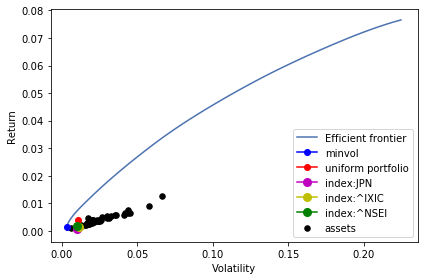

In [18]:
ef_shorts = EfficientFrontier(logret_mean, logret_std, weight_bounds=(-1,1))
ef_shorts_copy = EfficientFrontier(logret_mean, logret_std, weight_bounds=(-1,1))


minvol_ef_shorts = ef_shorts_copy.min_volatility()
minvol_ef_shorts_pwt = ef_shorts_copy.clean_weights()
minvol_ef_shorts_pwt = list(minvol_ef_shorts_pwt.values())

minvol_logret_std, minvol_logret_mean = get_portfolio_coordinates(minvol_ef_shorts_pwt)

ef_plt_shorts = pplt.plot_efficient_frontier(ef_shorts, showfig = False)
ef_plt_shorts.plot(minvol_logret_std, minvol_logret_mean, '-bo', label='minvol')
ef_plt_shorts.plot(uniform_logret_std, uniform_logret_mean, '-ro', label='uniform portfolio')

# plot indices
color_forms = ['-mo', '-yo', '-go']
for iticker, _color_form in zip(indices_tickers, color_forms):
    index_logret_mean, index_logret_std = estims.loc[iticker]
    ef_plt_shorts.plot(index_logret_std, index_logret_mean, 
                          _color_form,  markersize=8, label=f'index:{iticker}')

legend = plt.legend(loc='lower right')
plt.show()

## Portfolio with short sales with 10 stocks

из выбранных ранее 50 активов выберем 10 наиболее инвестиционно привлекательных

построим эффективный фронт с короткими продажами и без

In [19]:
tickers10 = tickers[:10]
tickers10

['PRFT', 'ANAT', 'III', 'WIRE', 'OFS', 'DXLG', 'PMBC', 'FTNT', 'CG', 'GAIN']

In [20]:
joint_data10 = pd.DataFrame(data=[], columns=[])
joint_data10['Date'] = data_for_ticker[tickers10[0]]['Date'][1:]

for ticker in tickers10:
    data = data_for_ticker[ticker]
    joint_data10[ticker] = data['logret'][1:]
    
joint_data10 = joint_data10.dropna()
del joint_data10['Date']
joint_data10

PRFT      ANAT       III      WIRE       OFS      DXLG      PMBC  \
1   -0.060564 -0.015323 -0.014670 -0.021321 -0.019513 -0.036368  0.000000   
2   -0.008811  0.015613  0.000000  0.004994 -0.012392  0.000000  0.000000   
3    0.019078 -0.003917  0.009804  0.000866 -0.010025 -0.037740 -0.002692   
4    0.024967  0.025685  0.019324  0.020774  0.019951  0.000000  0.039635   
5    0.043856  0.023797  0.018958  0.009703 -0.007435  0.037740  0.077249   
..        ...       ...       ...       ...       ...       ...       ...   
241  0.023865  0.002951  0.006671  0.007353  0.006626  0.052460 -0.001994   
242  0.020148 -0.003162 -0.003997 -0.003573 -0.007576  0.003401 -0.007011   
243  0.027634 -0.001003 -0.008043  0.041313  0.029965  0.003390 -0.024416   
244 -0.008350 -0.001269 -0.024524  0.027105  0.015561  0.036549 -0.020812   
245  0.031110 -0.000106  0.024524  0.014529 -0.010959  0.053981 -0.011634   

         FTNT        CG      GAIN  
1   -0.043432 -0.023956 -0.037696  
2   -0.008019  0.015773 -0.015729  
3   -0.066846 -0.025358  0.015729  
4    0.001991  0.018685  0.019026  
5    0.016323 -0.001971  0.008211  
..        ...       ...       ...  
241 -0.000717  0.007538  0.002118  
242  0.011416  0.011703  0.024383  
243  0.011893  0.028477  0.001376  
244  0.004705  0.003115  0.010937  
245  0.035672  0.008323  0.013505  

[245 rows x 10 columns]

In [21]:
logret_mean10 = joint_data10.mean()
logret_std10 =  joint_data10.cov()

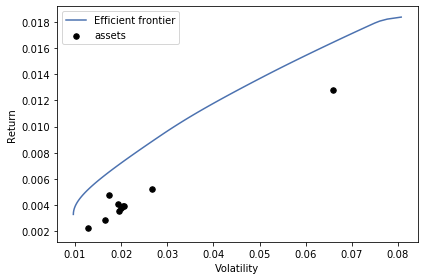

In [22]:
ef_shorts10 = EfficientFrontier(logret_mean10, logret_std10, weight_bounds=(-1,1))
ef_plt_shorts10 = pplt.plot_efficient_frontier(ef_shorts10, showfig = False)

## Portfolio without short sales with 10 stocks

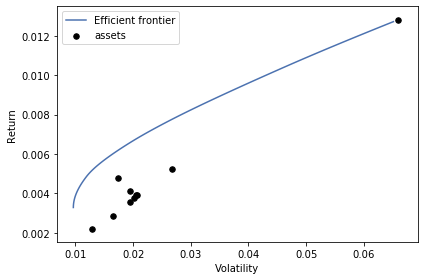

In [23]:
ef_no_shorts10 = EfficientFrontier(logret_mean10, logret_std10, weight_bounds=(0,1))
ef_plt_no_shorts10 = pplt.plot_efficient_frontier(ef_no_shorts10, showfig = False)

## Optimal portfolio without short sales with 50 stocks

находим оптимальные портфели в случае с короткими продажами и без

выбираем портфели с наибольшим коэффициентом шарпа

In [24]:
def getVaR(portfolio_mean, portfolio_std, tLvl):
    quantile = stats.norm.ppf(tLvl)
    return (portfolio_mean + portfolio_std*quantile)

In [25]:
ef_no_shorts = CLA(logret_mean, logret_std, weight_bounds=(0,1))
optimal_pfolio = ef_no_shorts.max_sharpe() 
optimal_pwt = ef_no_shorts.clean_weights()
optimal_pwt

OrderedDict([('PRFT', 0.03251),
             ('ANAT', 0.06291),
             ('III', 0.00451),
             ('WIRE', 0.0),
             ('OFS', 0.04655),
             ('DXLG', 0.02194),
             ('PMBC', 0.02917),
             ('FTNT', 0.05107),
             ('CG', 0.0),
             ('GAIN', 0.0),
             ('SBNY', 0.0),
             ('^NSEI', 0.15229),
             ('TGA', 0.02446),
             ('TRNS', 0.03832),
             ('AAVAS', 0.09752),
             ('PDBC', 0.0),
             ('JYNT', 0.00409),
             ('CRAI', 0.00397),
             ('CSWC', 0.0),
             ('ARLP', 0.0),
             ('UHAL', 0.0067),
             ('ADANIGREEN', 0.04529),
             ('JCOM', 0.0),
             ('ATLC', 0.0),
             ('ORMP', 0.0014),
             ('NYMTP', 0.11945),
             ('CBNK', 0.0),
             ('GOOG', 0.00773),
             ('TBBK', 0.0),
             ('TGLS', 0.00195),
             ('HMNF', 0.1466),
             ('ANGO', 0.0),
             ('PNNT', 0

In [26]:
optimal_pwt = list(optimal_pwt.values())

optimal_logret_std, optimal_logret_mean = get_portfolio_coordinates(optimal_pwt)

getVaR(optimal_logret_mean, optimal_logret_std, 0.95)

0.011697650644713401

## Optimal portfolio with short sales with 50 stocks

In [27]:
ef_shorts = CLA(logret_mean, logret_std, weight_bounds=(-1,1))
optimal_pfolio_short = ef_shorts.max_sharpe() 
optimal_pwt_short = ef_shorts.clean_weights()
optimal_pwt_short

OrderedDict([('PRFT', 0.08766),
             ('ANAT', 0.09096),
             ('III', 0.01958),
             ('WIRE', 0.04345),
             ('OFS', 0.04238),
             ('DXLG', 0.02738),
             ('PMBC', 0.09381),
             ('FTNT', 0.05546),
             ('CG', 0.02656),
             ('GAIN', 0.09657),
             ('SBNY', 0.07119),
             ('^NSEI', 0.10859),
             ('TGA', 0.03396),
             ('TRNS', 0.05825),
             ('AAVAS', 0.11684),
             ('PDBC', 0.13872),
             ('JYNT', 0.01437),
             ('CRAI', 0.0265),
             ('CSWC', -0.02076),
             ('ARLP', 0.02196),
             ('UHAL', 0.0835),
             ('ADANIGREEN', 0.04304),
             ('JCOM', -0.03064),
             ('ATLC', 0.00788),
             ('ORMP', -0.00688),
             ('NYMTP', 0.18539),
             ('CBNK', 0.02376),
             ('GOOG', 0.09106),
             ('TBBK', -0.0133),
             ('TGLS', 0.00675),
             ('HMNF', 0.15191),
   

In [28]:
optimal_pwt_short = list(optimal_pwt_short.values())

optimal_short_logret_std, optimal_short_logret_mean = get_portfolio_coordinates(optimal_pwt_short)

getVaR(optimal_short_logret_mean, optimal_short_logret_std, 0.95)

0.014229350400002262

## Optimal portfolio without short sales with 10 stocks

In [29]:
ef_no_shorts10 = CLA(logret_mean10, logret_std10, weight_bounds=(0,1))
optimal_pfolio10 = ef_no_shorts10.max_sharpe() 
optimal_pwt10 = ef_no_shorts10.clean_weights()
optimal_pwt10

OrderedDict([('PRFT', 0.20491),
             ('ANAT', 0.12414),
             ('III', 0.09254),
             ('WIRE', 0.0),
             ('OFS', 0.16982),
             ('DXLG', 0.06099),
             ('PMBC', 0.15155),
             ('FTNT', 0.15425),
             ('CG', 0.00409),
             ('GAIN', 0.03772)])

In [30]:
optimal_pwt10 = list(optimal_pwt10.values())

optimal10_logret_std, optimal10_logret_mean = get_portfolio_coordinates(weights=optimal_pwt10, 
                                                                        _tickers=tickers10, 
                                                                        _logret_mean=logret_mean10, 
                                                                        _logret_std=logret_std10)

getVaR(optimal10_logret_mean, optimal10_logret_std, 0.95)

0.02365748145683651

## Optimal portfolio with short sales with 10 stocks

In [31]:
ef_shorts10 = CLA(logret_mean10, logret_std10, weight_bounds=(-1,1))
optimal_pfolio_short10 = ef_shorts10.max_sharpe() 
optimal_pwt_short10 = ef_shorts10.clean_weights()
optimal_pwt_short10

OrderedDict([('PRFT', 0.2079),
             ('ANAT', 0.12556),
             ('III', 0.09299),
             ('WIRE', -0.00932),
             ('OFS', 0.17047),
             ('DXLG', 0.06107),
             ('PMBC', 0.1533),
             ('FTNT', 0.15406),
             ('CG', 0.00552),
             ('GAIN', 0.03845)])

In [32]:
optimal_pwt_short10 = list(optimal_pwt_short10.values())

optimal10_short_logret_std, optimal10_short_logret_mean = get_portfolio_coordinates(weights=optimal_pwt_short10, 
                                                                        _tickers=tickers10, 
                                                                        _logret_mean=logret_mean10, 
                                                                        _logret_std=logret_std10)

getVaR(optimal10_short_logret_mean, optimal10_short_logret_std, 0.95)

0.023678246953542394

## Risk-free asset 

возьмем виртуальный безрисковый актив и отобразим его на карте активов

ожидаемая доходность актива = 0.002

In [33]:
rf_logret_mean = 0.002
rf_logret_std = 0

fig_all.add_scatter(x=[rf_logret_std], y=[rf_logret_mean], text=['RISK-FREE'], mode="markers",
                marker=dict(size=10, color="Cyan"), name='RISK-FREE', secondary_y=False,)


### Risk-free with shorts 

построим оптимальный фронт в случае с  короткими продажами и отметим на нем безрисковый актив

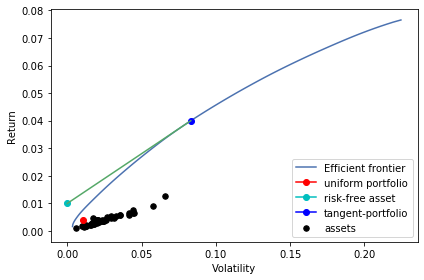

In [46]:
rf_logret_mean = 0.01

ef_shorts = EfficientFrontier(logret_mean, logret_std, weight_bounds=(-1,1))
ef_plt_shorts = pplt.plot_efficient_frontier(ef_shorts, showfig = False)
ef_plt_shorts.plot(uniform_logret_std, uniform_logret_mean, '-ro', label='uniform portfolio')
ef_plt_shorts.plot(rf_logret_std, rf_logret_mean, '-co', label='risk-free asset')

tangent_portfolio = ef_shorts.efficient_return(target_return=0.04)
tangent_portfolio_weights = list(tangent_portfolio.values())
tangent_logret_std, tangent_logret_mean = get_portfolio_coordinates(tangent_portfolio_weights)
ef_plt_shorts.plot(tangent_logret_std, tangent_logret_mean, '-bo', label='tangent-portfolio')

point1 = [rf_logret_std, rf_logret_mean]
point2 = [tangent_logret_std, tangent_logret_mean]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values)


legend = plt.legend(loc='lower right')
plt.show()

In [42]:
tangent_portfolio_weights[:40]

tangent_logret_std, tangent_logret_mean = get_portfolio_coordinates(weights=tangent_portfolio_weights)
tangent_var = getVaR(tangent_logret_mean, tangent_logret_std, 0.95)

print(f'(std, mean): {tangent_logret_std}, {tangent_logret_mean}')
print(f'var: {tangent_var}')
optimal_pwt10

(std, mean): 0.14861980006919445, 0.06000000000000004
var: 0.3044578171806172


[0.20491,
 0.12414,
 0.09254,
 0.0,
 0.16982,
 0.06099,
 0.15155,
 0.15425,
 0.00409,
 0.03772]

### Risk-free w/o shorts 

построим оптимальный фронт без коротких продаж и отметим на нем безрисковый актив

доходность безрискового актива выше доходности портфелей на оптимальном фронте

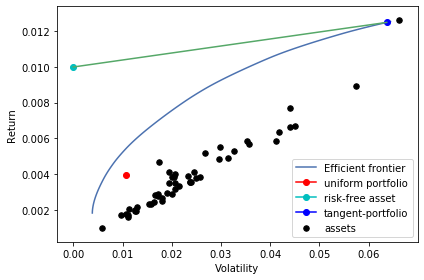

In [51]:
rf_logret_mean = 0.01

ef_shorts = EfficientFrontier(logret_mean, logret_std, weight_bounds=(0,1))
ef_plt_shorts = pplt.plot_efficient_frontier(ef_shorts, showfig = False)
ef_plt_shorts.plot(uniform_logret_std, uniform_logret_mean, '-ro', label='uniform portfolio')
ef_plt_shorts.plot(rf_logret_std, rf_logret_mean, '-co', label='risk-free asset')

tangent_portfolio = ef_shorts.efficient_return(target_return=0.0125)
tangent_portfolio_weights = list(tangent_portfolio.values())
tangent_logret_std, tangent_logret_mean = get_portfolio_coordinates(tangent_portfolio_weights)
ef_plt_shorts.plot(tangent_logret_std, tangent_logret_mean, '-bo', label='tangent-portfolio')

point1 = [rf_logret_std, rf_logret_mean]
point2 = [tangent_logret_std, tangent_logret_mean]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values)

legend = plt.legend(loc='lower right')
plt.show()

In [52]:
tangent_portfolio_weights[:40]

tangent_logret_std, tangent_logret_mean = get_portfolio_coordinates(weights=tangent_portfolio_weights)
tangent_var = getVaR(tangent_logret_mean, tangent_logret_std, 0.95)

print(f'(std, mean): {tangent_logret_std}, {tangent_logret_mean}')
print(f'var: {tangent_var}')
optimal_pwt10

(std, mean): 0.06366788069579436, 0.012500000000000004
var: 0.11722434448279098


[0.20491,
 0.12414,
 0.09254,
 0.0,
 0.16982,
 0.06099,
 0.15155,
 0.15425,
 0.00409,
 0.03772]